<a href="https://colab.research.google.com/github/poojan007/ICT619-Waste-Sorting-Assistant/blob/main/ICT619_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waste Sorting Algorithm

The project concerns waste classification to determine if it may be recycle or not. The dataset contains waste images recyclable and organic ones. We will try to train a model that will be able to recognise them all. It is a binary classification problem and we will train the model in TensorFlow.

Firstly, we unzip the dataset from google drive:

In [24]:
# prompt: load data from google drive and unzip it

!unzip -q /content/drive/MyDrive/ICT619-Dataset/archive.zip -d data


replace data/DATASET/TEST/O/O_12568.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/DATASET/TEST/O/O_12569.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/DATASET/TEST/O/O_12570.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/DATASET/TEST/O/O_12571.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace data/DATASET/TEST/O/O_12572.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data
The dataset contains images divided into two classes: organic waste and recycle waste and it is split into train data (85%) and test data (15%). Training dataset contains 22564 images while test dataset 2513 images.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os

import keras
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.layers import Dropout, Dense, Flatten, BatchNormalization

# Data preparation

In [4]:
train_dir = '/content/data/DATASET/TRAIN'
test_dir = '/content/data/DATASET/TEST'

We load images with image_dataset_from_directory - this method returns an object tf.data.Dataset.

We define some of parameters:

In [5]:
batch_size = 32
img_height = 64
img_width = 64

Create a dataset:

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 22564 files belonging to 2 classes.
Using 18052 files for training.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2513 files belonging to 2 classes.
Using 502 files for validation.


The class names can be found in the attribute class_names. They correspond to directory names in alphabetical order.

In [8]:
class_names = train_ds.class_names
print(class_names)

['O', 'R']


# Data visualization

Here there are first 9 images from the training dataset.

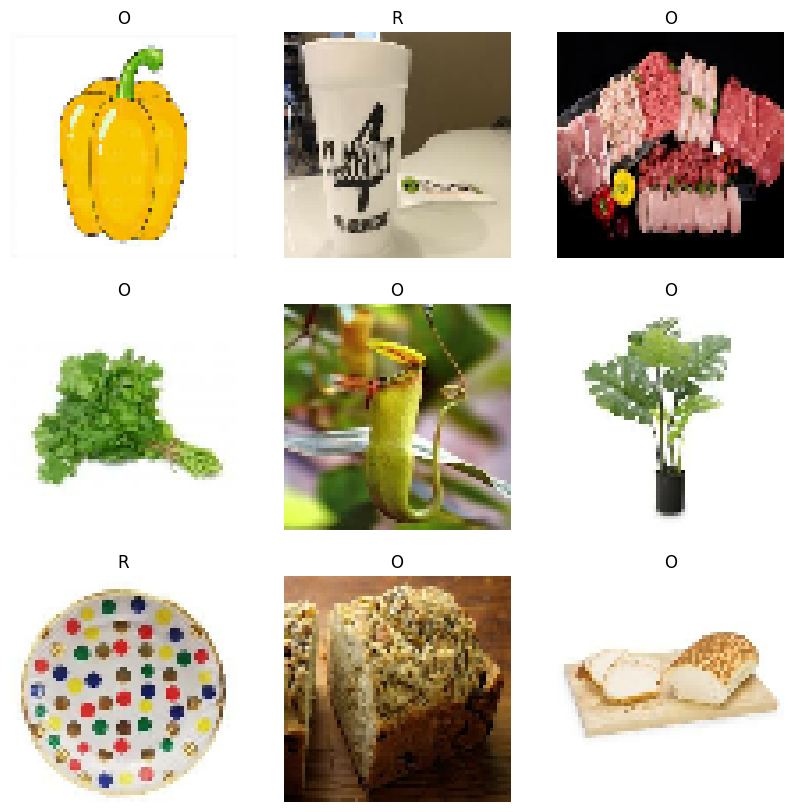

In [9]:
plt.figure(figsize= (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

Shape of data:

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 64, 64, 3)
(32,)


# Data standardization
The RGB channel values fall into the [0, 255] range. We have to standardize values to be in the [0, 1] range. We use a Rescaling layer for it.

In [11]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
X_train, y_train = next(iter(normalized_ds))
first_image = X_train[0]
print(np.min(first_image), np.max(first_image))

0.0074697463 1.0


In [13]:
normalized_test = test_ds.map(lambda x, y: (normalization_layer(x), y))
X_test, y_test = next(iter(normalized_test))
first_img = X_test[0]
print(np.min(first_img), np.max(first_img))

0.0 1.0


# Creating the model
We build model with Convolutional Neural Network (CNN) and we will test a few models.

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with three Dense layers. First two layers are activated by a relu activation function and the last is activated by a sigmoid activation function.

Compile the model:

We choose the Adam optimizer and the loss function: binary_crossentropy. To view training and validation accuracy for each training epoch, we use metrics "accuracy".

In [14]:
model = Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(64, 64, 3)),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
  tf.keras.layers.MaxPool2D((2,2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation="relu"),
  tf.keras.layers.Dense(units=64, activation="relu"),
  tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 64)          0

# Train the model
We train the model for 30 epoch.

In [16]:
history = model.fit(
    X_train, y_train,
    epochs = 30,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 0.6900 - accuracy: 0.5625 - val_loss: 0.7575 - val_accuracy: 0.3438
Epoch 2/30
1/1 [==============================] - 0s 491ms/step - loss: 0.6765 - accuracy: 0.5625 - val_loss: 0.6487 - val_accuracy: 0.6875
Epoch 3/30
1/1 [==============================] - 0s 376ms/step - loss: 0.6598 - accuracy: 0.5625 - val_loss: 0.7163 - val_accuracy: 0.3438
Epoch 4/30
1/1 [==============================] - 0s 384ms/step - loss: 0.6059 - accuracy: 0.6875 - val_loss: 0.7103 - val_accuracy: 0.5312
Epoch 5/30
1/1 [==============================] - 0s 442ms/step - loss: 0.5515 - accuracy: 0.7500 - val_loss: 0.5757 - val_accuracy: 0.7812
Epoch 6/30
1/1 [==============================] - 0s 438ms/step - loss: 0.5143 - accuracy: 0.8125 - val_loss: 0.7693 - val_accuracy: 0.5625
Epoch 7/30
1/1 [==============================] - 0s 437ms/step - loss: 0.4646 - accuracy: 0.7812 - val_loss: 0.6116 - val_accuracy: 0.7188
Epoch 8/30
1/1 [=======

In [17]:
loss, accuracy = model.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7500


# Visualization training results
The plots of loss and accuracy on the training and validation sets.

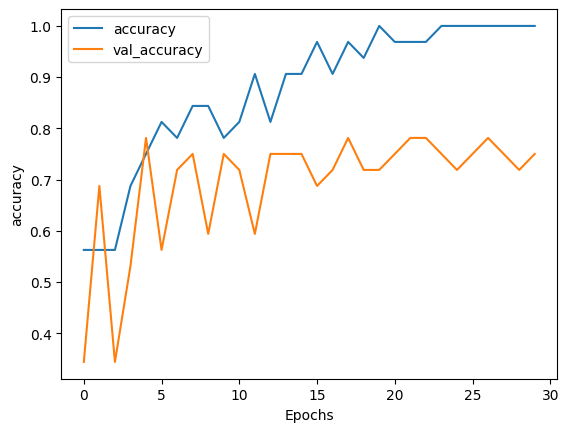

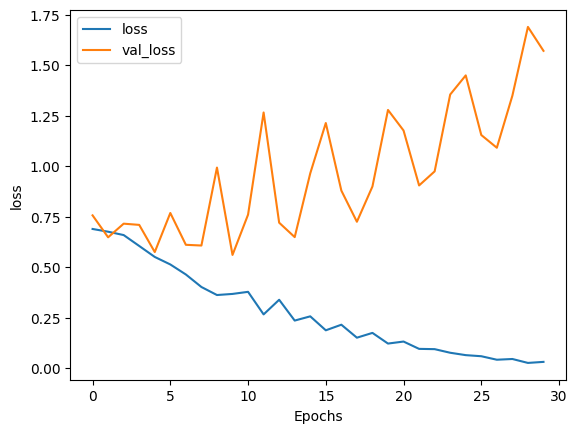

In [18]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

From the above plots one can see that difference in accuracy between training and validation set is noticeable. We are dealing with overfitting. The training accuracy is increasing over time, whereas validation accuracy achieved 75% in the training process.

In this case from this dataset is difficult to achieve good accuracy with a CNN created from scratch.

# Model 2

In model two we add additional convolution layers and we reduce the complexity of architecture in fully connected layer to have a better accuracy. We also are adding Dropout layer to fight with overfitting in the training process.

In [19]:
model2 = Sequential([
   tf.keras.layers.Conv2D(32, (3,3), input_shape=(64, 64, 3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
   tf.keras.layers.MaxPool2D((2,2)),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(64, activation="relu"),
   tf.keras.layers.Dropout(0.2),
   tf.keras.layers.Dense(32, activation="relu"),
   tf.keras.layers.Dense(1, activation="sigmoid")
])

model2.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                   metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 64)         

In [20]:
history_2 = model2.fit(
    X_train, y_train,
    epochs = 30,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
1/1 [==============================] - 2s 2s/step - loss: 0.7108 - accuracy: 0.5625 - val_loss: 0.7061 - val_accuracy: 0.3438
Epoch 2/30
1/1 [==============================] - 0s 263ms/step - loss: 0.6928 - accuracy: 0.5938 - val_loss: 0.7139 - val_accuracy: 0.3438
Epoch 3/30
1/1 [==============================] - 0s 248ms/step - loss: 0.6913 - accuracy: 0.5938 - val_loss: 0.7119 - val_accuracy: 0.3438
Epoch 4/30
1/1 [==============================] - 0s 257ms/step - loss: 0.6924 - accuracy: 0.5625 - val_loss: 0.7078 - val_accuracy: 0.3438
Epoch 5/30
1/1 [==============================] - 0s 251ms/step - loss: 0.6793 - accuracy: 0.6250 - val_loss: 0.7097 - val_accuracy: 0.3438
Epoch 6/30
1/1 [==============================] - 0s 256ms/step - loss: 0.6529 - accuracy: 0.6562 - val_loss: 0.7149 - val_accuracy: 0.3438
Epoch 7/30
1/1 [==============================] - 0s 369ms/step - loss: 0.6528 - accuracy: 0.5625 - val_loss: 0.7046 - val_accuracy: 0.3438
Epoch 8/30
1/1 [=======

In [21]:
loss, accuracy = model2.evaluate(X_train,y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9375
Testing Accuracy:  0.7812


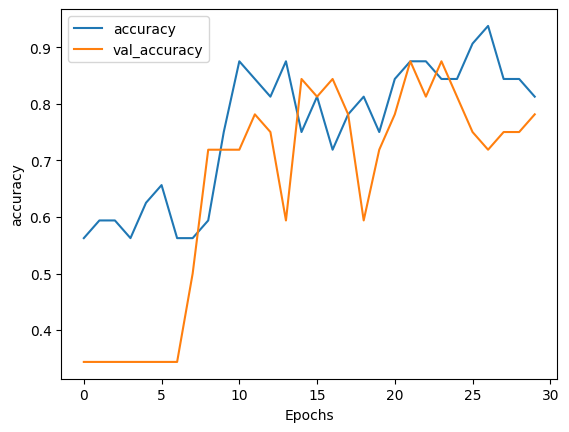

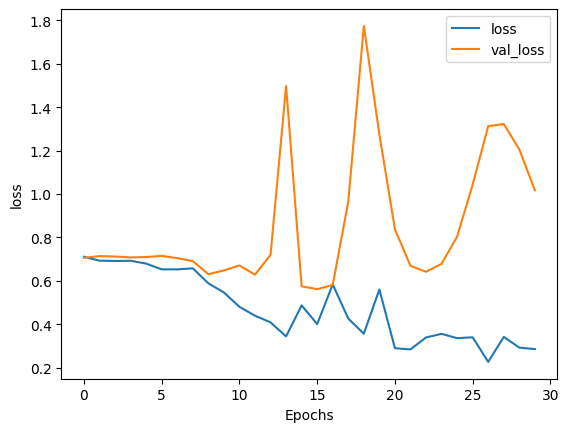

In [23]:
plot_graphs(history_2, "accuracy")
plot_graphs(history_2, "loss")

In [37]:
# add the image path
test_image = image.load_img('organic-waste-rubbish-bin-22055030.jpg', target_size = (64, 64))

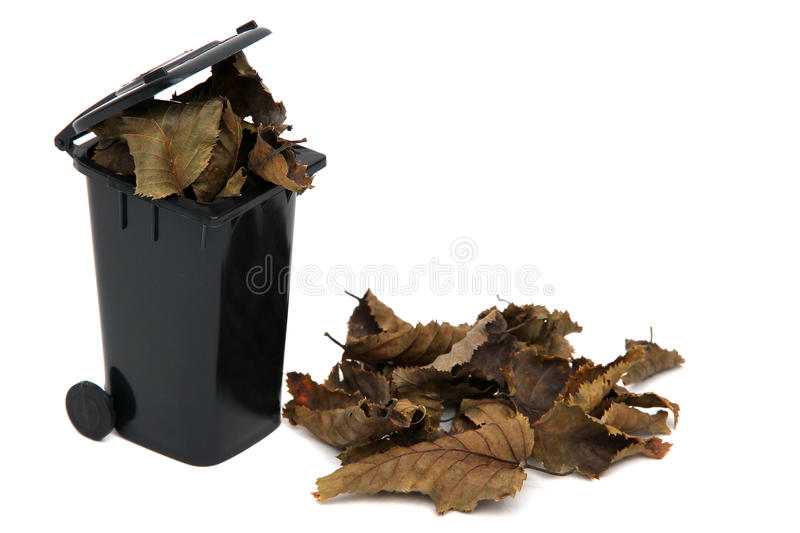

In [38]:
Image.open('organic-waste-rubbish-bin-22055030.jpg')

In [39]:
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

# prediction
result = model2.predict(test_image)

1/1 [==============================] - 0s 39ms/step


In [40]:
print(result)

[[1.]]


In [41]:
if result[0][0] == 1:
    prediction = 'Recyclable Waste'
else:
    prediction = 'Organic Waste'

print(prediction)

Recyclable Waste
